In [2]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 20.6 MB/s eta 0:00:00


In [3]:
# 📌 STEP 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
warnings.filterwarnings("ignore")

In [ ]:
# Install the Google API client library
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

# Import necessary libraries
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
import io
import os

# Authenticate to Google Drive
auth.authenticate_user()

# Build the Drive API client
drive_service = build('drive', 'v3')

# Replace with your file ID
file_id = '1lebLp_-OulqIJw-vKEc_bownBEhsi3jF'
file_name = 'train.csv.7z'  # Specify the desired file name

# Download the file
request = drive_service.files().get_media(fileId=file_id)
fh = io.BytesIO()
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))

# Save the file
with open(file_name, 'wb') as f:
    f.write(fh.getbuffer())

print(f'File "{file_name}" downloaded successfully.')

In [ ]:
import pandas as pd

try:
  # Attempt to read the CSV with optimized settings for large files
  train_chunks = pd.read_csv('train.csv',parse_dates=['date'] ,chunksize=10000) # Adjust chunksize as needed

  # Create an empty list to store chunks
  all_chunks = []

  # Process the data in chunks to avoid memory overload
  for chunk in train_chunks:
    # Perform operations on each chunk here
    print(chunk.shape)
    # ... your code to process each chunk ...

    # Append the chunk to the list
    all_chunks.append(chunk)

  # Concatenate all chunks into a single DataFrame
  #train = pd.concat(all_chunks, ignore_index=True)

except FileNotFoundError:
  print("Error: 'train.csv' not found.  Make sure the file exists and the path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

In [8]:
train = pd.concat(all_chunks, ignore_index=True)

In [15]:
#Load Datasets
stores = pd.read_csv("stores.csv")
items = pd.read_csv("items.csv")
holiday_events = pd.read_csv("holidays_events.csv")
transactions = pd.read_csv("transactions.csv",parse_dates=['date'])
oil = pd.read_csv("oil.csv",parse_dates=['date'])

In [11]:
# 🧹 Data Cleaning
train['unit_sales'] = train['unit_sales'].apply(lambda x: max(x, 0))  # remove negatives
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='ffill')

In [16]:
# 🔗 Merge for EDA
merged = train.merge(stores, on='store_nbr', how='left') \
              .merge(items, on='item_nbr', how='left') \
              .merge(transactions, on=['date', 'store_nbr'], how='left') \
              .merge(oil, on='date', how='left')

merged['transactions'].fillna(0, inplace=True)

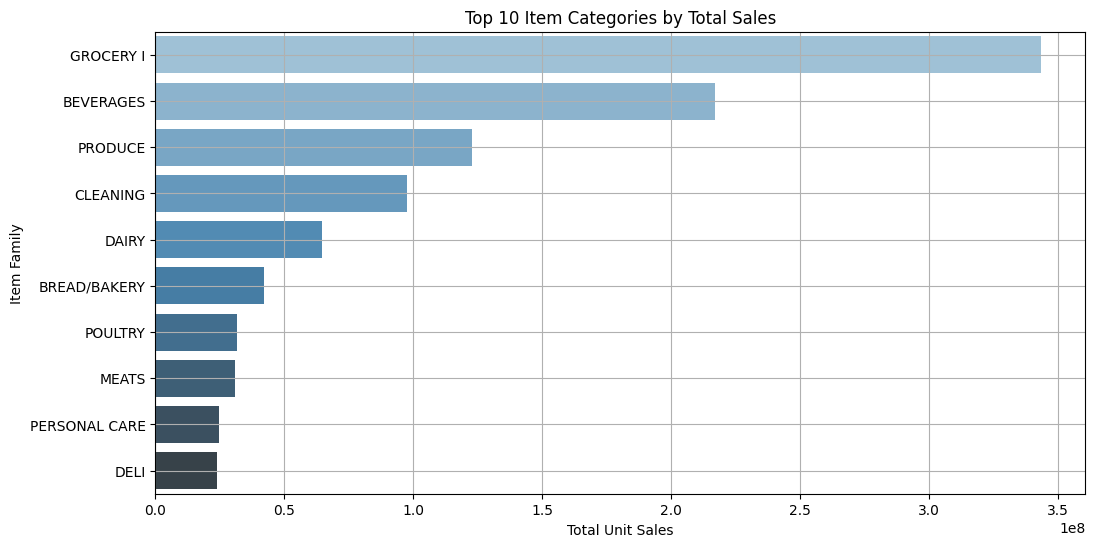

In [17]:
# 1️⃣ Top Item Families by Sales
plt.figure(figsize=(12,6))
top_families = merged.groupby('family')['unit_sales'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_families.values, y=top_families.index, palette='Blues_d')
plt.title("Top 10 Item Categories by Total Sales")
plt.xlabel("Total Unit Sales")
plt.ylabel("Item Family")
plt.grid()
plt.show()

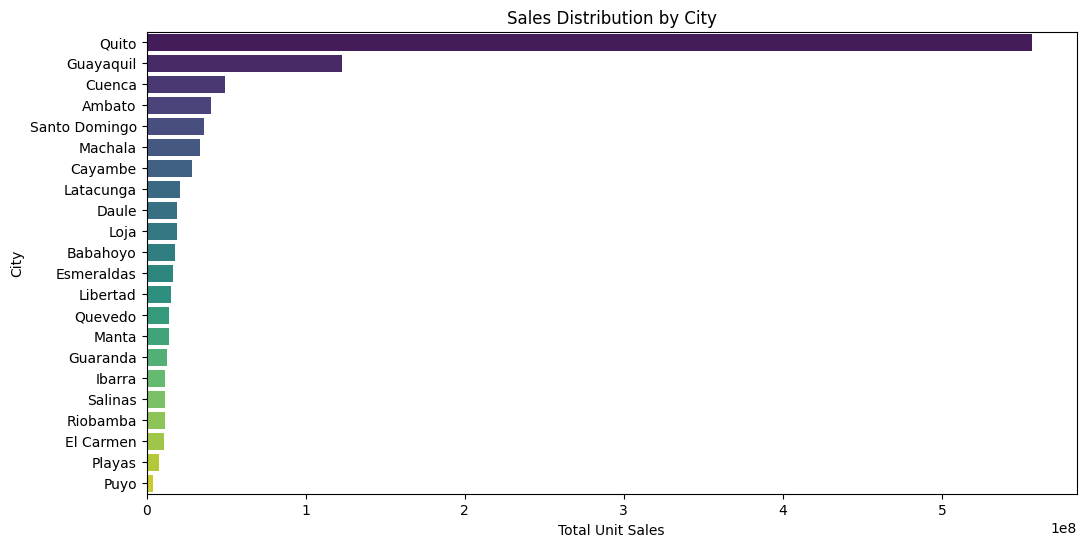

In [18]:
# 2️⃣ Sales by City
plt.figure(figsize=(12,6))
city_sales = merged.groupby('city')['unit_sales'].sum().sort_values(ascending=False)
sns.barplot(x=city_sales.values, y=city_sales.index, palette='viridis')
plt.title("Sales Distribution by City")
plt.xlabel("Total Unit Sales")
plt.ylabel("City")
plt.show()

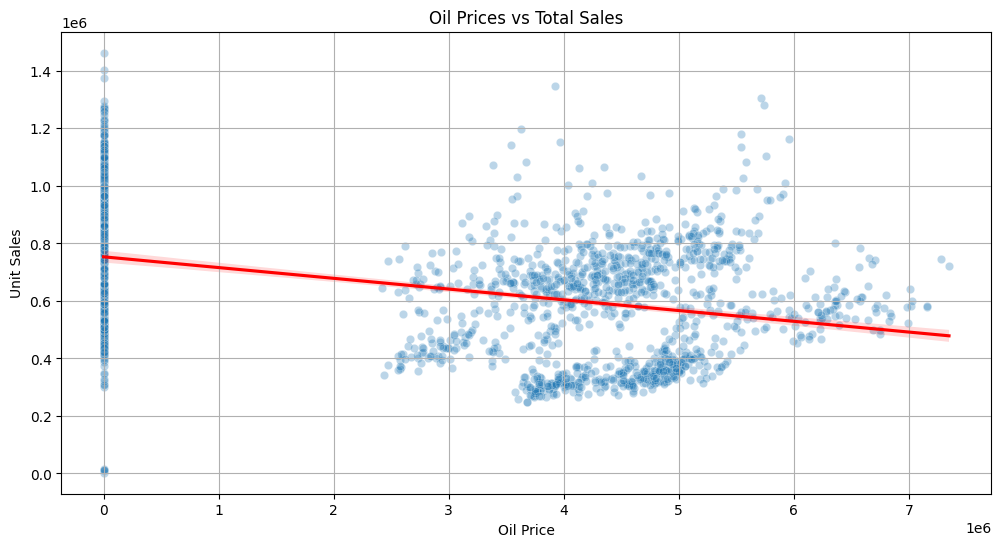

In [19]:
# 3️⃣ Oil Prices vs Sales
plt.figure(figsize=(12,6))
merged_oil = merged.groupby('date')[['unit_sales', 'dcoilwtico']].sum().reset_index()
sns.scatterplot(data=merged_oil, x='dcoilwtico', y='unit_sales', alpha=0.3)
sns.regplot(data=merged_oil, x='dcoilwtico', y='unit_sales', scatter=False, color='red')
plt.title("Oil Prices vs Total Sales")
plt.xlabel("Oil Price")
plt.ylabel("Unit Sales")
plt.grid()
plt.show()

In [20]:
# 4️⃣ Transactions vs Sales
plt.figure(figsize=(10,6))
sns.scatterplot(data=merged, x='transactions', y='unit_sales', alpha=0.2)
sns.regplot(data=merged, x='transactions', y='unit_sales', scatter=False, color='orange')
plt.title("Transactions vs Sales")
plt.xlabel("Transactions")
plt.ylabel("Unit Sales")
plt.grid()
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x78ca50b0a980> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x78ca50b084a0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# 5️⃣ Holidays Impact
holiday_events = holiday_events[holiday_events['transferred'] == False]
holiday_sales = merged.merge(holiday_events[['date', 'type']], on='date', how='left')
holiday_sales['holiday'] = holiday_sales['type'].notnull()
grouped = holiday_sales.groupby('holiday')['unit_sales'].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=grouped.index.map({True: 'Holiday', False: 'Non-Holiday'}), y=grouped.values, palette='Set2')
plt.title("Average Sales on Holidays vs Non-Holidays")
plt.ylabel("Average Unit Sales")
plt.show()

In [ ]:
# 6️⃣ Correlation Matrix
eda_corr = merged[['unit_sales', 'transactions', 'dcoilwtico']].copy()
eda_corr['unit_sales'] = np.log1p(eda_corr['unit_sales'])
eda_corr['transactions'] = np.log1p(eda_corr['transactions'])
eda_corr['dcoilwtico'] = eda_corr['dcoilwtico'].fillna(method='ffill')

plt.figure(figsize=(6,4))
sns.heatmap(eda_corr.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [21]:
# 🏪 Choose top item in top store
top_item = merged.groupby(['item_nbr'])['unit_sales'].sum().idxmax()
top_store = merged.groupby(['store_nbr'])['unit_sales'].sum().idxmax()

In [22]:
# 🧪 Filter dataset
ts_df = merged[(merged['item_nbr'] == top_item) & (merged['store_nbr'] == top_store)]
ts_df = ts_df[['date', 'unit_sales', 'transactions', 'dcoilwtico']].set_index('date')
ts_df = ts_df.asfreq('D')  # Daily frequency
ts_df = ts_df.fillna(method='ffill')  # Fill missing values

In [23]:
# ➗ Log-transform (stabilize variance)
ts_df['log_sales'] = np.log1p(ts_df['unit_sales'])
ts_df['log_trans'] = np.log1p(ts_df['transactions'])

In [24]:
# 🔪 Train-test split
cutoff_date = '2017-05-01'
train = ts_df.loc[:cutoff_date]
test = ts_df.loc[cutoff_date:]

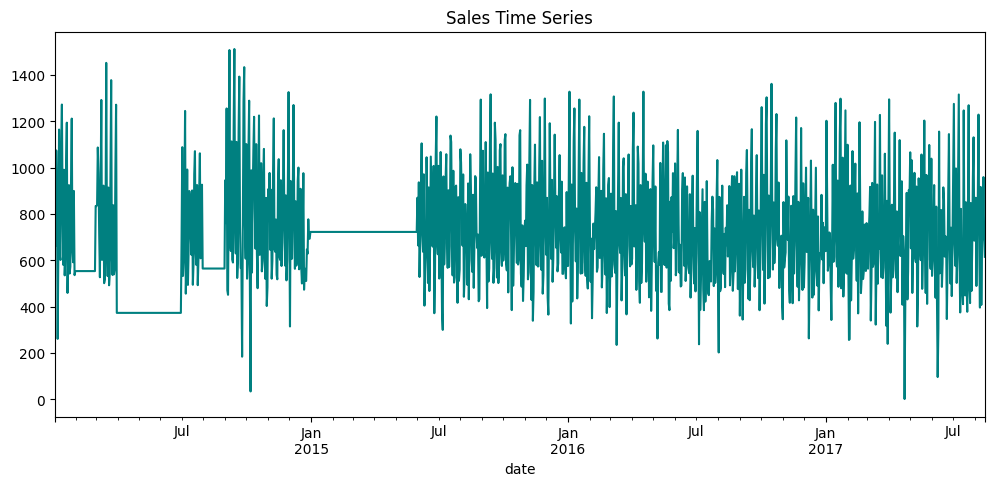

In [25]:
# 📈 Visualize
ts_df['unit_sales'].plot(figsize=(12,5), title="Sales Time Series", color='teal')
plt.show()

In [26]:
# 🧠 SARIMAX Model
model = SARIMAX(train['log_sales'],
                exog=train[['log_trans', 'dcoilwtico']],
                order=(1,1,1),
                seasonal_order=(1,1,1,7),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         log_sales   No. Observations:                 1216
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -215.327
Date:                           Thu, 10 Apr 2025   AIC                            444.655
Time:                                   07:27:37   BIC                            480.279
Sample:                               01-02-2014   HQIC                           458.075
                                    - 05-01-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
log_trans      0.0281      0.017      1.701      0.089      -0.004       0.060
dcoilwtico     0.0057      0.005      1.133

In [28]:
# 🔪 Train-test split
cutoff_date = '2017-05-01'
train = ts_df.loc[:cutoff_date]
test = ts_df.loc[cutoff_date:] #cutoff_date might be included in the test set

#Exclude the cutoff_date from test set to avoid duplication or overlap
test = test[test.index > cutoff_date]

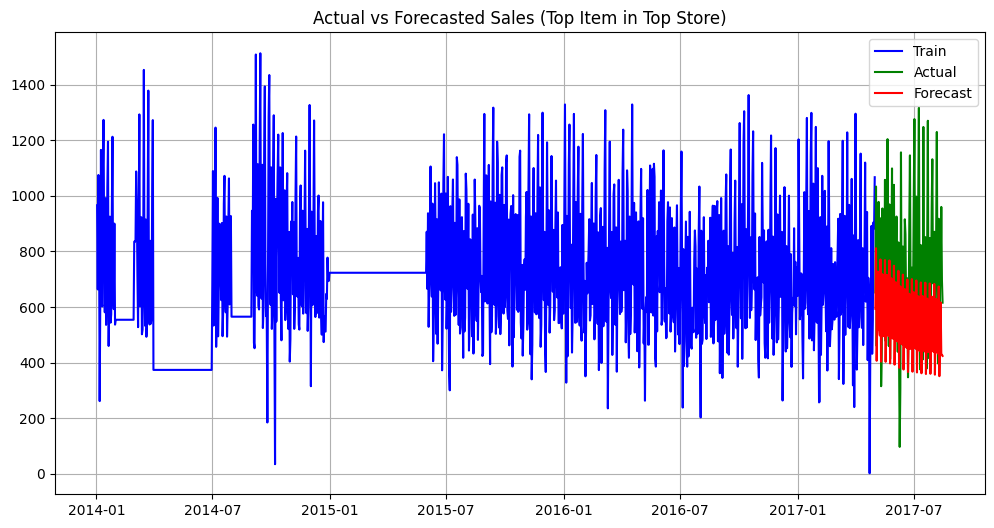

In [29]:
# Predict
forecast = results.predict(start=test.index[0], end=test.index[-1],
                           exog=test[['log_trans', 'dcoilwtico']])
forecast = np.expm1(forecast)  # Reverse log transform

# Compare
plt.figure(figsize=(12,6))
plt.plot(train.index, np.expm1(train['log_sales']), label="Train", color='blue')
plt.plot(test.index, test['unit_sales'], label="Actual", color='green')
plt.plot(test.index, forecast, label="Forecast", color='red')
plt.title("Actual vs Forecasted Sales (Top Item in Top Store)")
plt.legend()
plt.grid()
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error #Import mean_absolute_error
mae = mean_absolute_error(test['unit_sales'], forecast)
rmse = np.sqrt(mean_squared_error(test['unit_sales'], forecast))

print(f"📊 Model Performance on Test Set:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

📊 Model Performance on Test Set:
MAE: 216.95
RMSE: 298.02
